# Imports, setting up device and seeds


In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [2]:
import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

In [3]:
# torch.cuda.set_device(1)
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/My Drive/SSNElab9")

# Constants

In [6]:
VALIDATION_PERCENTAGE = 0.10
batch_size = 8
TRAIN_PATH = 'train.pkl'
TEST_PATH = "test_no_target.pkl"

# Reading training dataset

In [7]:
import pickle

with open(TRAIN_PATH, 'rb') as f:
    train = pickle.load(f)

In [8]:
train_lengths = [len(train_song[0]) for train_song in train]

In [9]:
len(train_lengths)

2939

In [10]:
type(train[0][0])

numpy.ndarray

# Histogram for training values

(array([152., 383., 229., 301., 297., 245., 212., 162., 103., 111.,  76.,
         67.,  87.,  49.,  42.,  37.,  23.,  27.,  22.,  25.,  17.,  16.,
         14.,  13.,  13.,  10.,  19.,  15.,  11.,  16.,   4.,   6.,   8.,
          8.,   2.,   5.,   3.,   5.,   5.,   5.,   6.,   4.,   4.,  11.,
          5.,   2.,   6.,   4.,   8.,   1.,   0.,   1.,   3.,   1.,   1.,
          2.,   1.,   2.,   0.,   2.,   1.,   2.,   3.,   0.,   0.,   0.,
          0.,   1.,   1.,   3.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.00000000e+00, 5.17575758e+01, 9.95151515e+01, 1.47272727e+02,
        1.95030303e+02, 2.42787879e+02

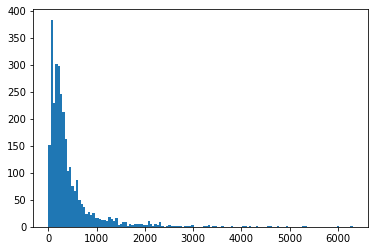

In [11]:
# histogram of lengths of training sequences
plt.hist(train_lengths, bins='auto')

In [12]:
min(train_lengths), max(train_lengths)

(4, 6308)

In [13]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

# Padding

In [14]:
from random import shuffle
from math import floor

# converting train to tensors
# train = [[torch.from_numpy(t[0].astype(int)).float(), torch.from_numpy(np.ndarray([int(t[1])]))] for t in train]
train_data = [[torch.from_numpy(t[0].astype(int)).float(), int(t[1])] for t in train]

dataset_length = len(train_data)
val_size = floor(dataset_length * VALIDATION_PERCENTAGE)
train_size = dataset_length - val_size

train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_subset_data = [item[0] for item in train_subset]
train_subset_targets = [item[1] for item in train_subset]

val_subset_data = [item[0] for item in val_subset]
val_subset_targets = [item[1] for item in val_subset]

train_set = VariableLenDataset(train_subset_data, train_subset_targets)
val_set = VariableLenDataset(val_subset_data, val_subset_targets)

In [15]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    return xx_pad, yy

In [16]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [17]:
next(iter(train_loader))

(tensor([[145., 145.,  12.,  ...,   0.,   0.,   0.],
         [ -1., 112.,  34.,  ...,   0.,   0.,   0.],
         [ -1.,  -1.,  -1.,  ...,   0.,   0.,  -1.],
         ...,
         [110., 185.,  88.,  ...,   0.,   0.,   0.],
         [ 12.,  12.,  12.,  ...,   0.,   0.,   0.],
         [ 21., 116.,  21.,  ...,   0.,   0.,   0.]]),
 (0, 4, 1, 4, 3, 0, 0, 2))

# Model

In [18]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # pass the input through the LSTM layer
        # print(x.shape)
        # print(hidden[0].size(0))
        out, _ = self.lstm(x, hidden)

        # print("OUT", out.shape)
        
        # get the last output of the LSTM layer
        out = out[-1, :, :]

        # print("OUT2", out.shape)
        
        # pass the last output through the fully-connected layer
        out = self.fc(out)

        # print("OUT3", out.shape)
        
        return out


In [19]:
    
model = LSTMRegressor(1,20,2,5).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2, dropout=0.4)
  (fc): Linear(in_features=20, out_features=5, bias=True)
)

In [20]:
def get_accuracy_per_class(model, loader, classes):

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    acurracy_sum = 0

    # again no gradients needed
    with torch.no_grad():
        for x, targets in loader:
        
            targets = torch.from_numpy(np.asarray(targets))
            # print("SHAPE X", x.shape)
            # print("SHAPE TARGETS", targets.shape)
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device) 
            x = torch.transpose(x, 0, 1)
            preds = model(x, (hidden, state))
            _, predictions = torch.max(preds, 1)

            for label, prediction in zip(targets, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        # print("Accuracy for class {:5s} is: {:.2f} %".format(classname, 
        #                                                accuracy))
        acurracy_sum += accuracy
        
    # print("Average accuracy for a class is: {:.2f} %".format(acurracy_sum/len(classes)))
    
    # division by 100
    return acurracy_sum/(len(classes) * 100)


# Training

In [21]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fun = nn.CrossEntropyLoss()

epochs, losses, train_acc, val_acc, train_acc_per_class, val_acc_per_class  = [], [], [], [], [], []

best_model = None
best_model_acc = None

# Training loop
for epoch in range(1000):
    correct_train = 0
    total_train = 0
    for x, targets in train_loader:
        targets = torch.from_numpy(np.asarray(targets))
        # print("SHAPE X", x.shape)
        # print("SHAPE TARGETS", targets.shape)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 

        # print(hidden.shape, state.shape)
        
        x = torch.transpose(x, 0, 1)
        # print("A")
        preds = model(x, (hidden, state))
        # print("B")
        # preds = torch.transpose(preds, 0, 1)
        # preds = preds.squeeze(2)
        # print("PREDS", preds.shape)
        # preds = preds[:,-1,:]
        
#         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        # preds = preds.squeeze(2)
        optimizer.zero_grad()

        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()

        # get the predicted labels
        _, predicted = torch.max(preds.data, 1)


        # compute the accuracy
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()


    losses.append(loss.item())
    epochs.append(epoch)

    # evaluate the model on the validation set
    correct = 0
    total = 0
    for x, targets in val_loader:
        targets = torch.from_numpy(np.asarray(targets))
        # print("SHAPE X", x.shape)
        # print("SHAPE TARGETS", targets.shape)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 

        # print(hidden.shape, state.shape)
        
        x = torch.transpose(x, 0, 1)
        preds = model(x, (hidden, state))

        # forward pass
        outputs = model(x, (hidden, state))

        # get the predicted labels
        _, predicted = torch.max(outputs.data, 1)


        # compute the accuracy
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # appending
    train_acc.append(100 * correct_train / total_train)
    val_acc.append(100 * correct / total)
    train_acc_per_class_for_epoch = get_accuracy_per_class(model, train_loader, range(0, 5))
    train_acc_per_class.append(train_acc_per_class_for_epoch)
    val_acc_per_class_for_epoch = get_accuracy_per_class(model, val_loader, range(0, 5))
    val_acc_per_class.append(val_acc_per_class_for_epoch)

    if best_model is None or val_acc_per_class_for_epoch > best_model_acc:
        # taking accuracy per class
        best_model = model
        best_model_acc = val_acc_per_class_for_epoch

    # print the accuracy
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    print(f"Accuracy on the validation set: {100 * correct / total}")
    print(f"Accuracy per class on train: {train_acc_per_class_for_epoch:.3}")
    print(f"Accuracy per class on val: {val_acc_per_class_for_epoch:.3}")

Epoch: 0, loss: 0.868
Accuracy on the validation set: 53.24232081911263
Accuracy per class on train: 0.253
Accuracy per class on val: 0.248
Epoch: 1, loss: 1.65
Accuracy on the validation set: 56.996587030716725
Accuracy per class on train: 0.25
Accuracy per class on val: 0.262
Epoch: 2, loss: 1.32
Accuracy on the validation set: 53.58361774744027
Accuracy per class on train: 0.257
Accuracy per class on val: 0.25
Epoch: 3, loss: 1.07
Accuracy on the validation set: 58.3617747440273
Accuracy per class on train: 0.244
Accuracy per class on val: 0.264
Epoch: 4, loss: 0.901
Accuracy on the validation set: 56.996587030716725
Accuracy per class on train: 0.246
Accuracy per class on val: 0.245
Epoch: 5, loss: 1.08
Accuracy on the validation set: 58.70307167235495
Accuracy per class on train: 0.242
Accuracy per class on val: 0.241
Epoch: 6, loss: 1.64
Accuracy on the validation set: 57.33788395904437
Accuracy per class on train: 0.244
Accuracy per class on val: 0.251
Epoch: 7, loss: 1.33
Accur

In [22]:
def plot_results(epochs, losses, train_acc, val_acc, train_acc_per_class, val_acc_per_class):
    # plotting
    plt.figure(figsize=(20,70), dpi=30,)
    # fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    plt.subplot(1,3,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,3,2)
    plt.title("Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    plt.subplot(1,3,3)
    plt.title("Accuracy per class")
    plt.plot(epochs, train_acc_per_class, label="Train")
    plt.plot(epochs, val_acc_per_class, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy per class")

    fig.tight_layout()

<Figure size 600x2100 with 0 Axes>

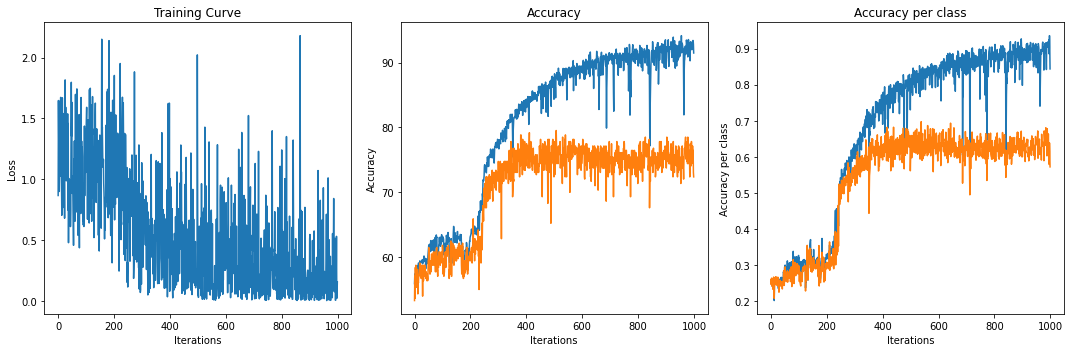

In [23]:
plot_results(epochs, losses, train_acc, val_acc, train_acc_per_class, val_acc_per_class)

In [24]:
# saving model to file
state_dict = model.state_dict()
torch.save(state_dict, "neural_net.tar")

In [25]:
# saving bes model to file
state_dict = best_model.state_dict()
torch.save(state_dict, "best_neural_net.tar")

In [36]:
print("Accuracy per class on the validation set: ", best_model_acc)

Accuracy per class on the validation set:  0.6976152843630986


# Predictions on test set

In [37]:
with open(TEST_PATH, 'rb') as f:
    test_data = pickle.load(f)

In [38]:
model = best_model

In [39]:
type(test_data)

list

In [40]:
train_loader

In [41]:
test_data = [torch.from_numpy(t.astype(int)).float() for t in test_data]

In [42]:
test_dataset = VariableLenDataset(test_data, [0 for t in test_data])

In [43]:
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [44]:
preds = []
for x, label in test_loader:
  print(x)
  hidden, state = model.init_hidden(x.shape[0])
  hidden, state = hidden.to(device), state.to(device)
  x = x.to(device).unsqueeze(2)
  x = torch.transpose(x, 0, 1)
  new_preds = model(x, (hidden, state))
  for new_pred in new_preds:
    preds.append(new_pred.max(0, keepdim=True)[1].item())

tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   2.,  ...,   0.,   0.,   0.],
        [ -1.,  64.,  64.,  ...,   0.,   0.,   0.],
        ...,
        [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
        [144.,  69., 100.,  ...,   0.,   0.,   0.],
        [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.]])
tensor([[ 12.,  47.,  28.,  ...,   0.,   0.,   0.],
        [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
        [ 12.,  47.,  47.,  ...,   0.,   0.,   0.],
        ...,
        [  7., 158.,  92.,  ...,   0.,   0.,   0.],
        [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
        [ 67.,  47.,  47.,  ...,   0.,   0.,   0.]])
tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [-1., -1.,  0.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0., 12., 12.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ...,  0.,  0.,  0.]])
tensor([[ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
      

In [45]:
preds_filename = "preds.csv"
pd.DataFrame({'A': preds}).to_csv(preds_filename, index=False, header=False)

In [46]:
pd.read_csv(preds_filename, header=None)


,0
0,0
1,0
2,0
3,2
4,0
...,...
1098,4
1099,4
1100,2
1101,2
